# 230968248
## KP Sai Praneeth

This notebook demonstrates the `Instruct Seg Edit` pipeline:
- Use custom segmentation model to produce segmentation masks conditioned on text prompts.
- Visualize the predicted mask over the original image.
- Use a Stable Diffusion ControlNet inpainting pipeline to edit only the segmented region.

Notes: run on a machine with a CUDA GPU for reasonable performance. Paths below assume repository root layout.

# Instruct Seg Edit

A pipeline that isolates the segment to be edited and diffuses the segment to localize the edits without touching other parts of the image.

Quick overview of the steps below:
1. Load a segmentation model.
2. Run prediction for a text prompt and obtain masks.
3. Visualize the mask overlaid on the original image for verification.
4. Prepare ControlNet / inpainting pipeline inputs (Canny edges, mask).
5. Run the inpainting pipeline to modify only the masked region.

Keep each cell short and runnable in order. If you change `img_path` or model paths, re-run from the top.

In [1]:
import torch
from ultralytics import FastSAM

# Change this path if you placed the model elsewhere. Using .cuda() pins the model to GPU 0.
model = FastSAM("models/instruct-seg-edit/best.pt").cuda(device=torch.device('cuda:0')) # Model based on FastSAM/YOLO architecture

In [2]:
# Provide an input image and a text prompt to guide segmentation
img_path = "data/sa-1b-000001-images/sa_22339.jpg" # sample from outside of training data
prompt = "a drone"

# Run the FastSAM prediction. The API returns a list of predictions for the input(s).
prediction = model.predict(img_path, texts=[prompt])


image 1/1 /mnt/d/Projects/DLProject/data/sa-1b-000001-images/sa_22339.jpg: 704x1024 1 object, 93.5ms
Speed: 6.0ms preprocess, 93.5ms inference, 4472.9ms postprocess per image at shape (1, 3, 704, 1024)


In [3]:
# Inspect the raw mask container returned by FastSAM
prediction[0].masks

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
orig_shape: (1500, 2250)
shape: torch.Size([1, 704, 1024])
xy: [array([[     834.96,      618.16],
       [     832.76,      620.36],
       [     826.17,      620.36],
       ...,
       [     850.34,      620.36],
       [     843.75,      620.36],
       [     841.55,      618.16]], shape=(563, 2), dtype=float32)]
xyn: [array([[    0.37109,     0.41211],
       [    0.37012,     0.41357],
       [    0.36719,     0.41357],
       ...,
       [    0.37793,     0.41357],
       [      0.375,     0.41357],
       [    0.37402,     0.41211]], shape=(563, 2), dtype=float32)]

In [4]:
# Extract the masks tensor
mask = prediction[0].masks.data
mask

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')

In [5]:
# Quick shape check to understand dimensions: (N, H, W) or (1, H, W)
mask.shape

torch.Size([1, 704, 1024])

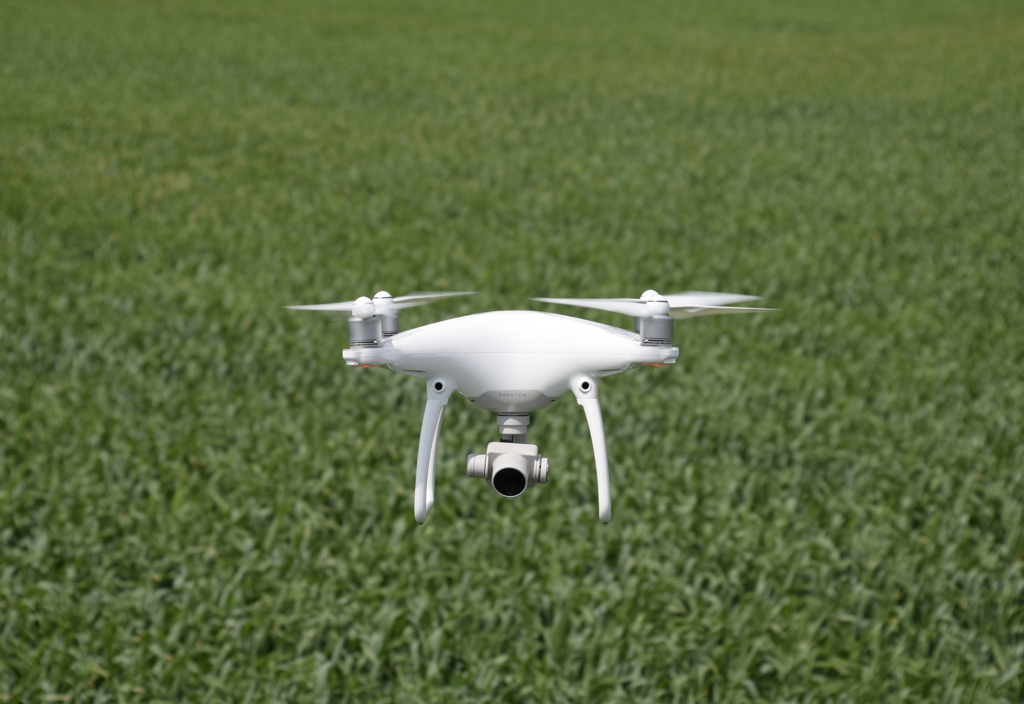

In [6]:
# Load the original image and resize it to match the mask spatial dimensions.
from PIL import Image

# Note: mask.shape index order may be (N, H, W) so we pick width=mask.shape[2], height=mask.shape[1]
orig = Image.open(img_path).resize((mask.shape[2], mask.shape[1]))
orig

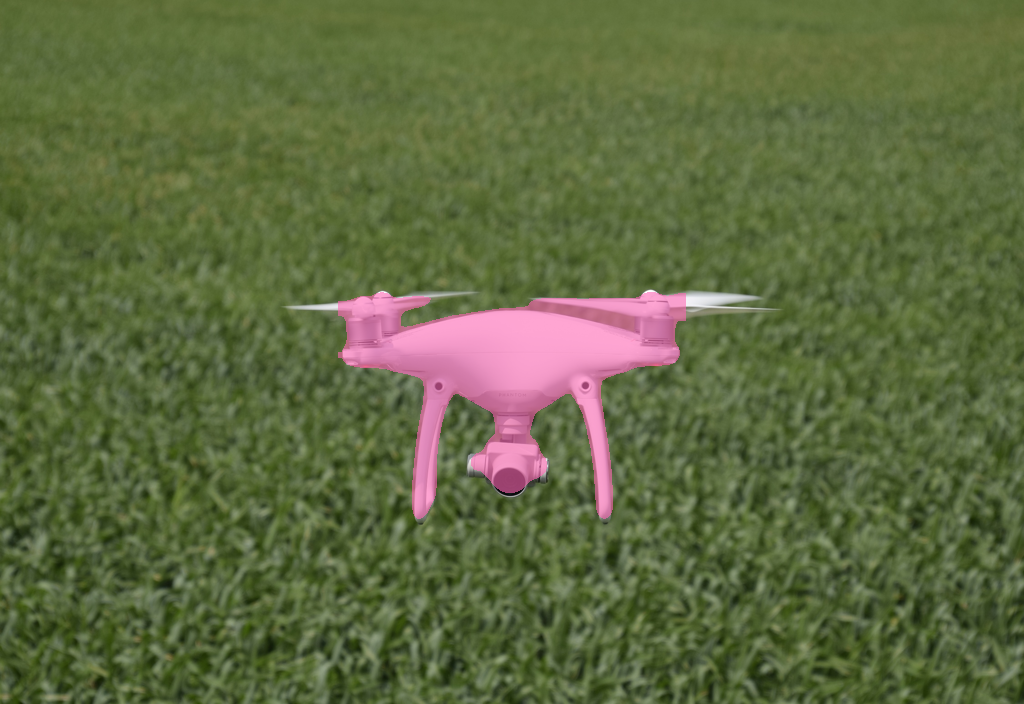

In [7]:
# Create a colored overlay for the predicted mask and blend it with the original image for quick visual QA.
import numpy as np

overlay = np.array([255, 105, 180])  # pink overlay color (RGB)
alpha = 0.6  # overlay transparency

image_np = np.array(orig.convert('RGB'))

# Convert the first mask to a boolean numpy array; adjust index if multiple masks exist.
mask_np = mask.squeeze(0).cpu().numpy().astype(bool)

# Apply overlay only to masked pixels and create a PIL Image for display
image_np[mask_np] = (image_np[mask_np] * (1 - alpha) + overlay * alpha).astype(np.uint8)

result_image = Image.fromarray(image_np)
result_image

In [8]:
# Setup ControlNet + inpainting pipeline from Diffusers. This cell prepares the model but does not run the heavy inpainting step.
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler

# Load a ControlNet model (Canny variant) and the inpainting checkpoint. Using float16 reduces memory but requires compatible GPU.
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16)

# Use UniPCMultistepScheduler for fast sampling and move pipeline to GPU
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
An error occurred while trying to fetch /home/prxneeth/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/prxneeth/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /home/prxneeth/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/prxneeth/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to rais

StableDiffusionControlNetInpaintPipeline {
  "_class_name": "StableDiffusionControlNetInpaintPipeline",
  "_diffusers_version": "0.35.1",
  "_name_or_path": "runwayml/stable-diffusion-inpainting",
  "controlnet": [
    "diffusers",
    "ControlNetModel"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "UniPCMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [9]:
# Prepare control image (Canny edges) and mask image, then run the inpainting pipeline to alter only the masked region.
import cv2

image_np = np.array(orig)
# Canny requires a single-channel image; thresholds may need tuning per image
canny_edges = cv2.Canny(image_np, 100, 200)
control_image = Image.fromarray(canny_edges)

# Convert mask to 0-255 PIL image for inpainting mask input (white=keep/edit region)
mask_np = mask.squeeze(0).cpu().numpy()
mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))

# Seed the generator for reproducible outputs; change or remove for randomness
generator = torch.manual_seed(42)

# Run the inpainting pipeline. This step is the most compute-heavy and may take significant GPU memory/time.
new_image = pipe(
    prompt="a pink drone",
    image=orig,
    mask_image=mask_image,
    control_image=control_image,
    num_inference_steps=25,
    generator=generator
).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

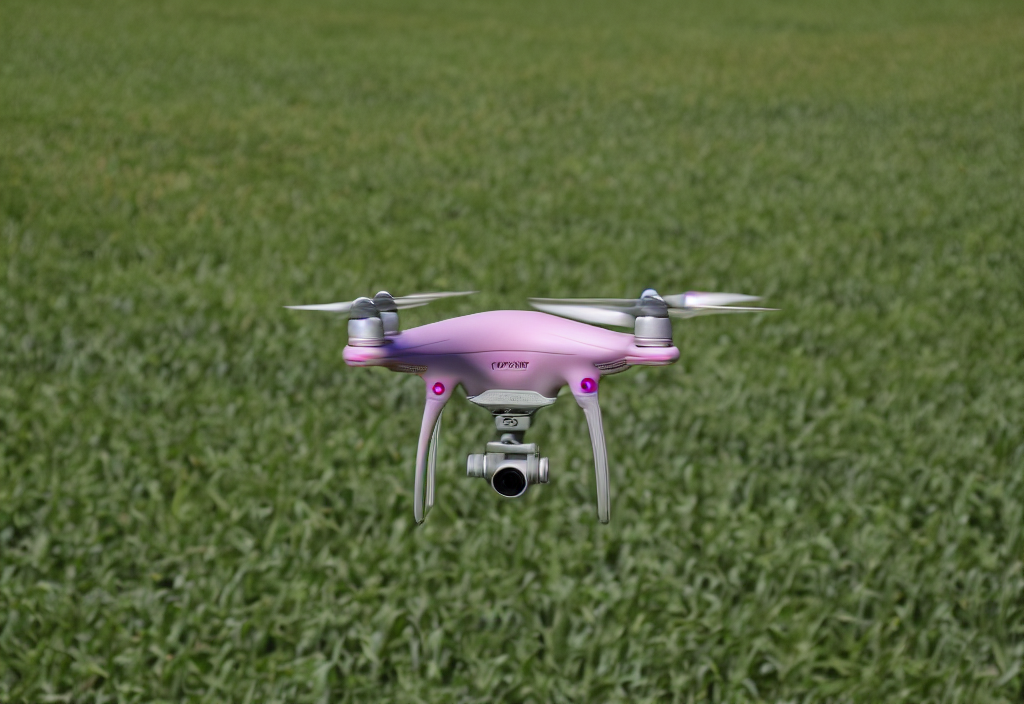

In [10]:
# Show the final result image
new_image

### The model was trained on an Nvidia A100 GPU for 38 hours (7 epochs)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("train_data/results.csv")

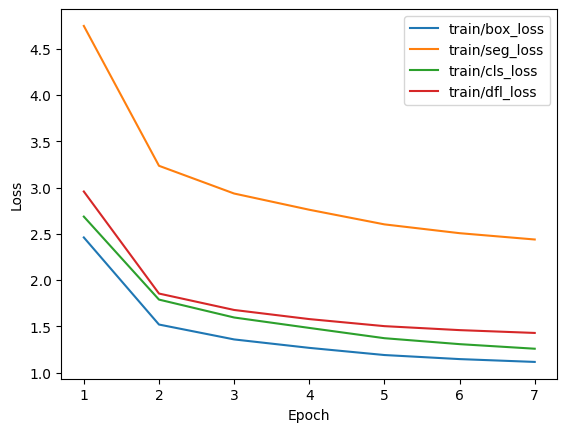

In [3]:
plt.plot(range(1, len(df) + 1), df[["train/box_loss", "train/seg_loss", "train/cls_loss", "train/dfl_loss"]])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train/box_loss", "train/seg_loss", "train/cls_loss", "train/dfl_loss"])
plt.show()

### Some metrics were measured during validation of the model

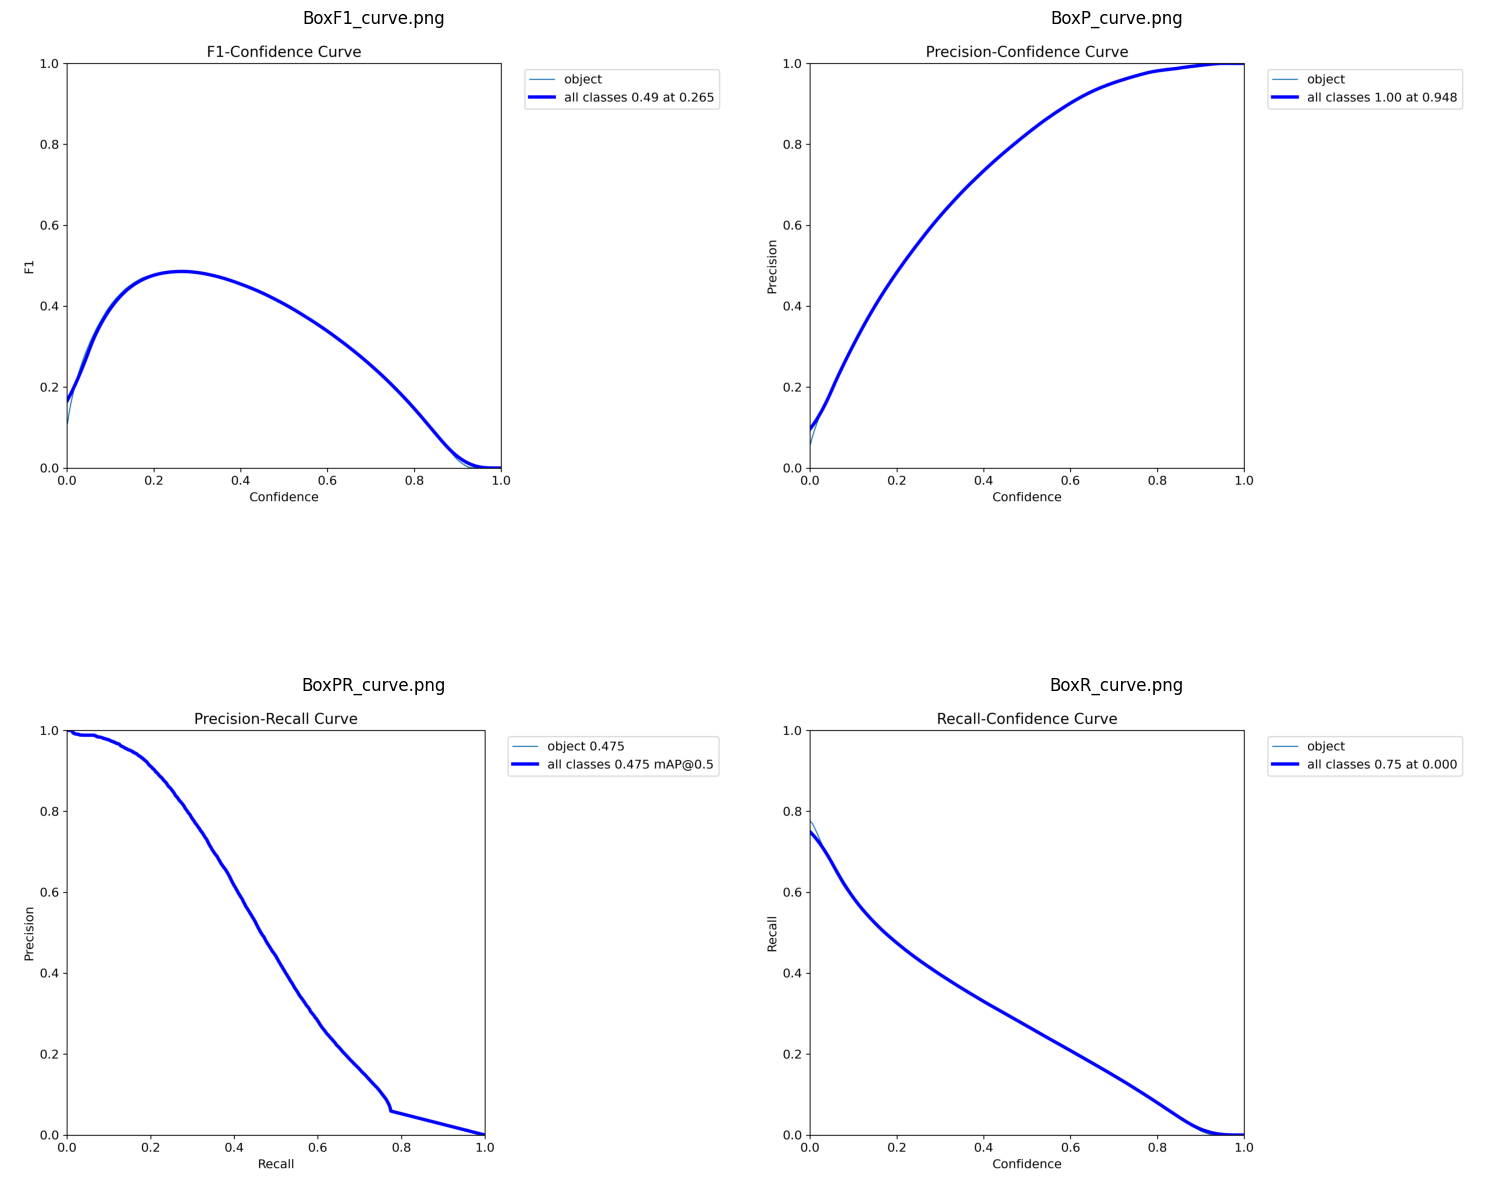

In [4]:
box_scores = [
    "train_data/val3/BoxF1_curve.png",
    "train_data/val3/BoxP_curve.png",
    "train_data/val3/BoxPR_curve.png",
    "train_data/val3/BoxR_curve.png",
]

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for i, score in enumerate(box_scores):
    img = plt.imread(score)
    ax[i // 2, i % 2].imshow(img)
    ax[i // 2, i % 2].axis('off')
    ax[i // 2, i % 2].set_title(score.split('/')[-1])
plt.tight_layout()
plt.show()

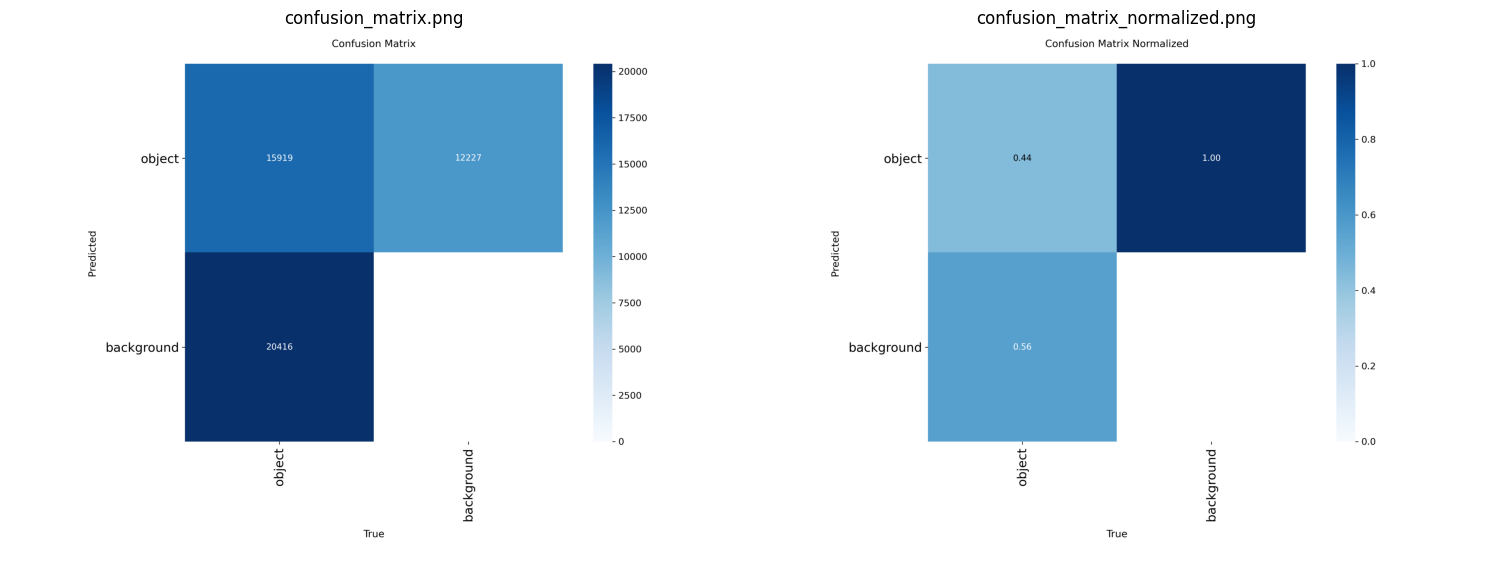

In [5]:
confusion_matrices = [
    "train_data/val3/confusion_matrix.png",
    "train_data/val3/confusion_matrix_normalized.png",
]

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
for i, cm in enumerate(confusion_matrices):
    img = plt.imread(cm)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(cm.split('/')[-1])
plt.tight_layout()
plt.show()

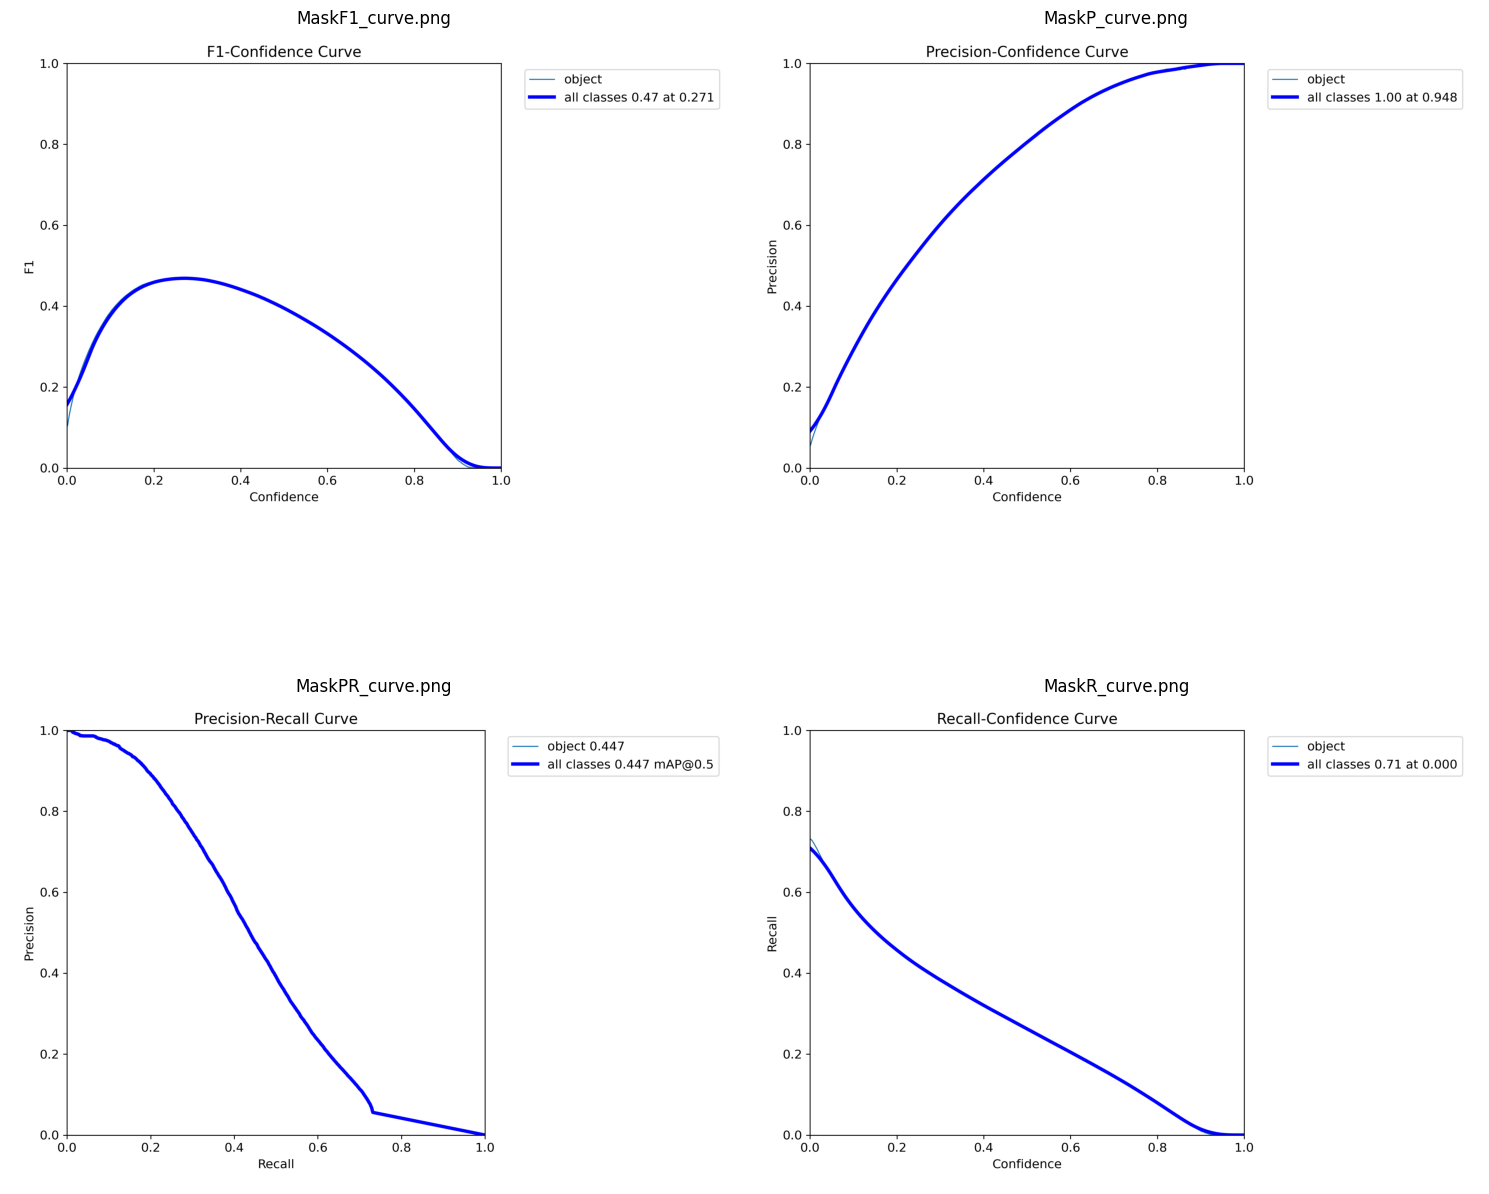

In [6]:
mask_score = [
    "train_data/val3/MaskF1_curve.png",
    "train_data/val3/MaskP_curve.png",
    "train_data/val3/MaskPR_curve.png",
    "train_data/val3/MaskR_curve.png"
]

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for i, score in enumerate(mask_score):
    img = plt.imread(score)
    ax[i // 2, i % 2].imshow(img)
    ax[i // 2, i % 2].axis('off')
    ax[i // 2, i % 2].set_title(score.split('/')[-1])
plt.tight_layout()
plt.show()

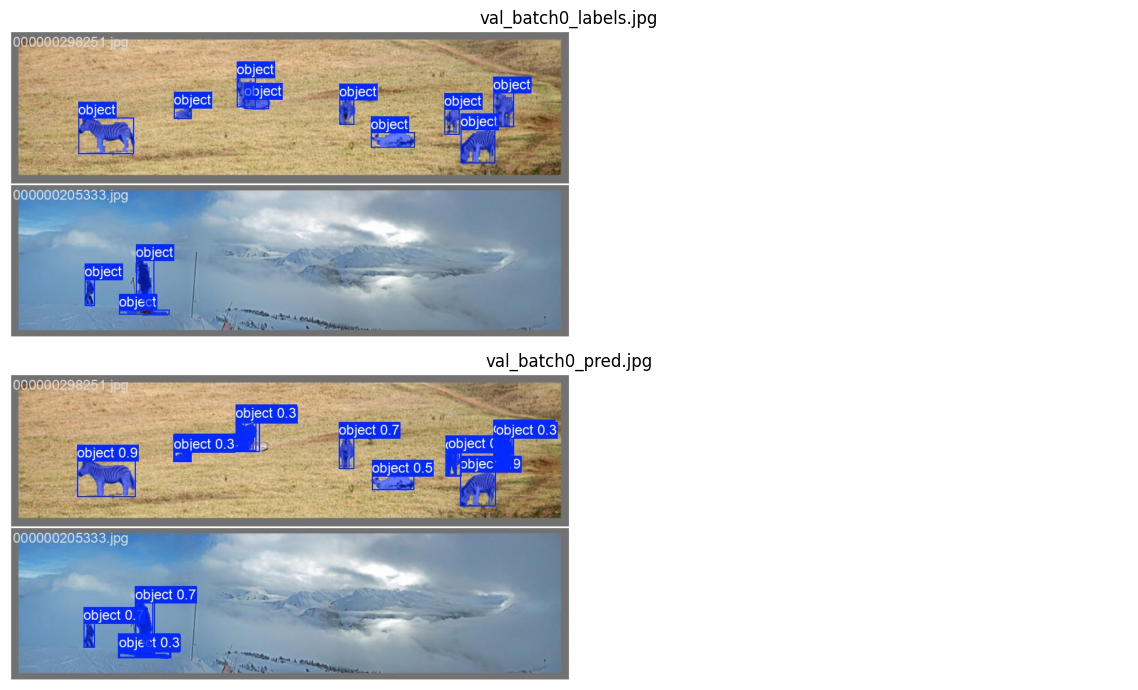

In [7]:
preds = [
    "train_data/val3/val_batch0_labels.jpg",
    "train_data/val3/val_batch0_pred.jpg",
]

fig, ax = plt.subplots(2, 1, figsize=(15, 7))
for i, pred in enumerate(preds):
    img = plt.imread(pred)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(pred.split('/')[-1])
plt.tight_layout()
plt.show()

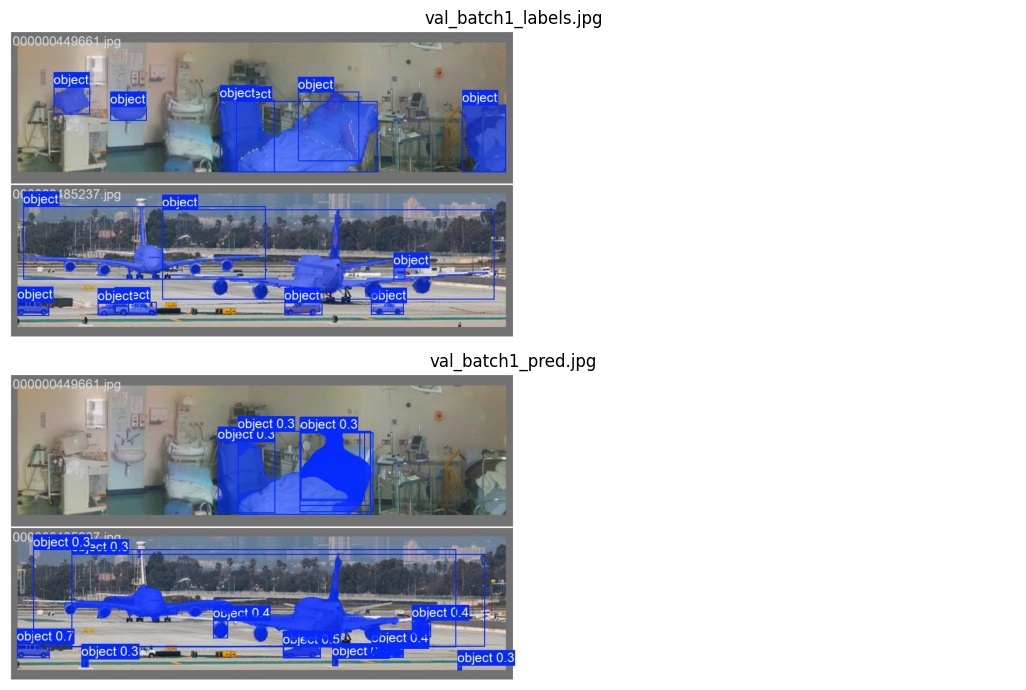

In [8]:
preds = [
    "train_data/val3/val_batch1_labels.jpg",
    "train_data/val3/val_batch1_pred.jpg",
]

fig, ax = plt.subplots(2, 1, figsize=(15, 7))
for i, pred in enumerate(preds):
    img = plt.imread(pred)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(pred.split('/')[-1])
plt.tight_layout()
plt.show()

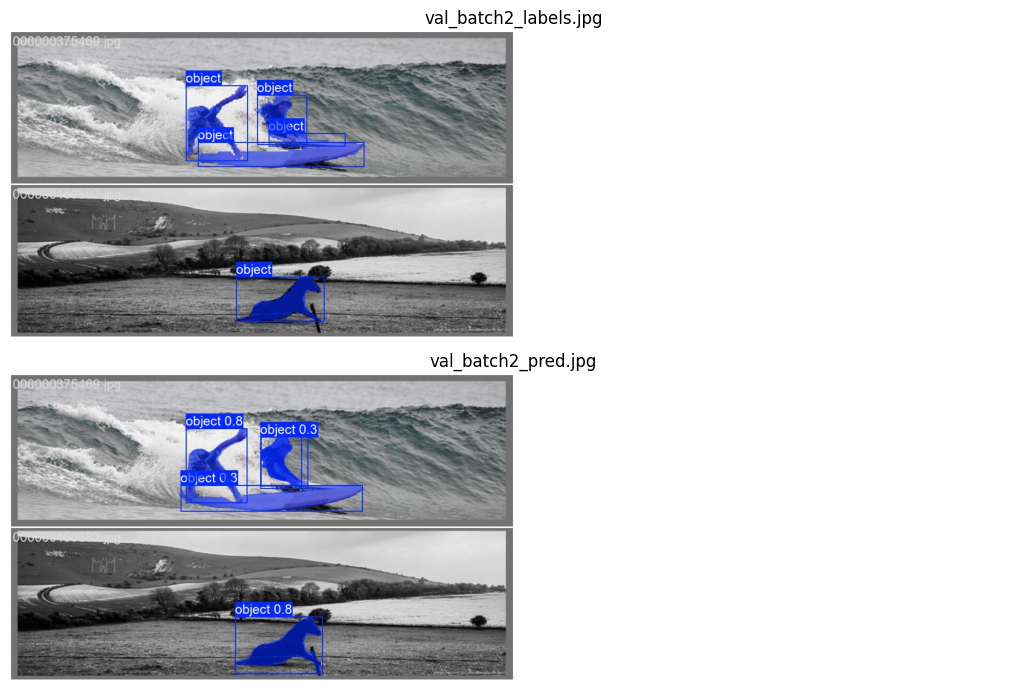

In [9]:
preds = [
    "train_data/val3/val_batch2_labels.jpg",
    "train_data/val3/val_batch2_pred.jpg",
]

fig, ax = plt.subplots(2, 1, figsize=(15, 7))
for i, pred in enumerate(preds):
    img = plt.imread(pred)
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(pred.split('/')[-1])
plt.tight_layout()
plt.show()

The model has learned to segment properly but it cannot identify all objects with 100% accuracy

### Future Plans

* The segmentation model needs to be trained on object detection before segmentation task. As it uses a similar architecture to `YOLO`, it is easy to train the model on object detection. This model can later be fine-tuned for segmentation task.
* The inpainting model is still a pre-trained model. Building one from scratch for this specific use-case would make it much better.
* Making a `Qwen-Image-Edit` style inpainting model for diffusing text elements will make this pipeline state-of-the-art.
* Using multiple datasets like SA-1B, COCO-seg etc. for training the segmentation model for object detection and segmentation would make it more versatile and generalised.
* Similarly, multiple datasets like COCO, Flickr300k etc. for inpainting diffusion model will help.